In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from scipy.stats import poisson
from tqdm.notebook import tqdm

In [2]:
import random
import tensorflow as tf

In [3]:
# Define drift and diffusion terms of stochastic process

def drift(x,kappa,theta):
    
    return kappa*(theta-x)


def diff(x,sigma):
    
    return sigma
    

In [4]:
# Function for Compound Poisson process for the jump term 

def normal_generator(mu_jump, sigma_jump, num_events):
    return np.random.normal(mu_jump, sigma_jump, num_events)

def compound_poisson_process(rate, dt, mu_jump, sigma_jump):
    num_events = np.random.poisson(rate*dt, size = 1)
    jumps = normal_generator(mu_jump = mu_jump, sigma_jump = sigma_jump, num_events = num_events)
    
    jump = jumps.sum()

    if len(jumps) == 0:
        jump = 0
        
    return jump

#mu_jump = 0.0
#sigma_jump = 1.0
#num_events_simulated = 50

#x = compound_poisson_process(10, 0.1, mu_jump, sigma_jump)
#plt.title("Sample Compound Poisson Process (Binomial)")
#plt.xlabel("time")
#plt.ylabel("events")
#plt.legend()

In [5]:
# Function to generate the evolution of a CTMC with given initial state, generator matrix and maturity

def ctmc(R_0, Q, dt, T):
    
    R_0 = int(R_0)
    T = float(T)
    
    #T = 1.  # Total time.
    n = int(T / dt)  # Number of time steps.
    t = np.linspace(0., T, n)
    
    if len(t) == 0.0:
        return [R_0], [T]
        
    Q_rates = Q[~np.eye(Q.shape[0],dtype=bool)].reshape(Q.shape[0],-1)
    
    states = [R_0]
    event_time = t[0]
    times = [t[0]]
    #n = 0 
    
    lambdas = [sum(Q_rates[i]) for i in range(len(Q_rates))]
    #lambdas_sum = np.cumsum(lambdas)
    
    while event_time <= T:
        
        R = states[len(states) - 1]
        l_i = lambdas[R]
        l_sum = np.cumsum(Q_rates[R])

        rate = sum(Q_rates[R])
       
        holding_time = np.random.exponential(scale = 1 / rate)

        event_time = event_time + holding_time
        if event_time <= T:
            times.append(event_time)

            u = np.random.uniform() 

            j = np.min(np.where(u <= (l_sum / l_i))[0])  ### Check! 

            if j >= R: 
                state_new = j + 1
            else:
                state_new = j 

            #print(f'state{ state_new}')

            states.append(state_new)

    return states, times        
    

In [6]:
# Function for finite-horizon path simulation of jump regime switching OU process, with a given stopping value

def ou_jump_sim_rs_stopping(kappa_vec, theta_vec, sigma_vec, mu_jump, sigma_jump, rate, dt, x_0, n_sim, stopping, Q, R_0, T, PD_flag):
    
    R_0 = int(R_0)
    T = float(T)
    #T = 1.  # Total time.
    n = int(T / dt)  # Number of time steps.
    t = np.linspace(0., T, n)  # Vector of times.
    x = np.zeros(n)
    
    if len(x) == 0.0:
        ruin_prob = 0.0 if x_0 <= stopping else 1.0 
        return [x_0], ruin_prob, [R_0], [T]
    
    
    x[0] = x_0
    x_origin = x
    x_list = list()
    ruin_count = 0
    
    regime_states, regime_times = ctmc(R_0, Q, dt, T)
    
    regime_times.append(T)
    
    
    for j in range(n_sim):
        
        if n-1 == 0:
            stopping_factor = 0.0 if ((isinstance(stopping, float)) and (x[0] <= stopping)) else 1.0
        else:
        
            for i in range(n - 1):

                # For regime-switch
                time_interval_index = np.min(np.where(regime_times > t[i])[0])  ### Check!
            
                state = regime_states[time_interval_index - 1]

                kappa = kappa_vec[state]
                theta = theta_vec[state]
                sigma = sigma_vec[state]

                stopping_factor = 0.0 if ((isinstance(stopping, float)) and (x[i] <= stopping)) else 1.0
                
                if PD_flag and (np.array([kappa, theta, sigma]) == 0.0).all():
                    
                    stopping_factor = 0.0
                    x[i] = stopping

                jump = compound_poisson_process(rate, dt, mu_jump, sigma_jump)

                x[i + 1] = x[i] + stopping_factor*(drift(x[i], kappa=kappa, theta=theta)*dt + diff(x[i], sigma = sigma)*np.sqrt(dt)*np.random.randn() \
                                + jump)
            
#             if sigma**2 < kappa*(theta-x[i])*dx:
#                 print('Condition flag')
            
#             x[i + 1] = x[i] + stopping_factor*(dx)
            
            
        #plt.plot(t, x.copy(), lw=1)
        x_list.append(x.copy())
        x = x_origin
        
        if stopping_factor == 0.0:
                ruin_count += 1
                
        stopping_factor = 1.0
        
    ruin_prob = ruin_count / n_sim    
    
    #plt.show()
        
    #X_tf = tf.stack(x_list)
    return x_list, ruin_prob, regime_states, regime_times

In [7]:
# prob_list_ex = []

# for start in tqdm(np.linspace(0.0, 1.0, 101)):
    
#     sigma = 0.5
#     kappa = 0.3
#     theta = 0.7
#     mu_jump = 0.0
#     sigma_jump = 0.5
#     rate = 1.0
#     dt = 0.01
#     x_0 = start
#     n_sim = 5000
#     stopping = 0.0

#     ou, prob = ou_jump_sim_stopping(kappa = kappa, theta = theta, sigma = sigma, mu_jump = mu_jump, sigma_jump = sigma_jump, rate = rate, 
#                      dt = dt, x_0 = x_0, n_sim = n_sim, stopping = stopping)
    
#     prob_list_ex.append(prob)
    

#     print(prob)

In [8]:
#plt.plot(np.linspace(0.0, 1.0, 101), prob_list_ex)

# Neural network ruin probability estimations - Levy Jump OU 

In [9]:
# Payoff function for default with 1 if the process has defaulted and 0 else

def g_func(path, stopping):
    
    #T = 1.  # Total time.
    #n = int(T / dt)  # Number of time steps.
    #t = np.linspace(0., T, n)
    
    #path, ruin = ou_sim_2(kappa, theta, sigma, dt, x_0, 1, stopping)
    
    #g = tf.constant(1.0) if (tf.math.reduce_any(path <= 0)) else tf.constant(0.0)
    g = tf.constant(1.0) if (np.any(np.array(path) <= 0)) else tf.constant(0.0)
    return g
    

In [10]:
# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
# Q = np.array([[-0.5, 0.3, 0.2], 
#     [0.3, -0.6, 0.3],   
#     [0.2, 0.3, -0.5]])
# kappa_vec = np.array([0.3,0.2,0.2])
# theta_vec = np.array([0.5, 0.8, 0.2])
# sigma_vec = np.array([0.5, 0.3, 0.6])

Q = np.array([[-0.5, 0.3, 0.2], 
    [0.3, -0.6, 0.3],   
    [0.0, 0.0, -0.0]])
kappa_vec = np.array([0.3,0.2,0.0])
theta_vec = np.array([0.8, 0.5, 0.0])
sigma_vec = np.array([0.3, 0.5, 0.0])

mu_jump = 0.0
sigma_jump = 0.5
rate = 1.0
stopping = 0.0

dt = 0.0001

# Set boundary values for initial position and convert to tensorflow
xmin = -6.0
xmax = 6.0

lb = tf.constant([xmin], dtype=DTYPE)
ub = tf.constant([xmax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(100)

# Set number of path simulations
N_sim = 50000

# Draw random initial positions, maturity times, and initial regimes for path simulations
X_0_data = tf.random.uniform((N_sim,1), lb, ub, dtype=DTYPE)
t_data = tf.random.uniform((N_sim,1), 0.0, 1.0, dtype = DTYPE)
R_data = tf.cast(tf.reshape(tf.random.categorical(tf.math.log([[1/3,1/3,1/3]]), N_sim), (N_sim,1)),tf.float32)

# Concatenate all parameters that will constitute model input into tensorflow format
process_data = tf.concat([X_0_data, t_data, R_data], axis=1)

# Simulate path for each (x, rho, t) and append paths in list that will be used for training
path_data_list = []
for i in tqdm(range(len(X_0_data))):
    
    path_data, ruin, states, times =  ou_jump_sim_rs_stopping(kappa_vec = kappa_vec, theta_vec = theta_vec, 
                                                              sigma_vec = sigma_vec, mu_jump = mu_jump, 
                                                              sigma_jump = sigma_jump, rate = rate, dt = dt, x_0 = X_0_data[i], 
                                                              n_sim = 1, stopping = 0.0, Q = Q, R_0 = R_data[i],  T = t_data[i], PD_flag = True)
        
    path_data_list.append(path_data.copy())
    
## Make the paths a tensor for compatability with the NN architecture    
#path_data_list = tf.stack(path_data_not_tf)   

  0%|          | 0/50000 [00:00<?, ?it/s]

<ipython-input-5-98498e8092e6>:33: RuntimeWarning: divide by zero encountered in double_scalars
  holding_time = np.random.exponential(scale = 1 / rate)


In [1]:
#np.save('path_data_list_rs_r_input.npy', np.array(path_data_list))

In [13]:
#path_data_list = np.load('path_data_list_rs_r_input.npy', allow_pickle=True)

In [11]:
# Neural network parameters
num_hidden_layers = 5
num_neurons_per_layer = 10

# Initializing the feedforwad neural network
model_jump = tf.keras.Sequential()

# Input is one-dimensional (only space & fixed time)
model_jump.add(tf.keras.Input(3))

# # Scaling layer to map input to [lb, ub]
# scaling_layer = tf.keras.layers.Lambda(lambda x:
#                                       2.0*(x-lb)/(ub-lb)-1.0)
# model_jump.add(scaling_layer)

# Append hidden layers 
for _ in range(num_hidden_layers):
        model_jump.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('softplus'),
            kernel_initializer='glorot_uniform'))
        
# Output is one-dimensional
model_jump.add(tf.keras.layers.Dense(1))

In [12]:
# Compute loss functon

def loss_function(model_jump, process_data, path_data_list):
    
    loss = 0.0
    
    for i in range(len(process_data)):
        
        path_values = path_data_list[i]
        
        g = g_func(path = path_values, stopping = 0.0)
        
        # Predict PD value
        pred = model_jump(process_data[i:(i+1)])
        # Compute loss as the squared difference between the payoff and model prediction (method by Frey)
        loss += tf.square(g - pred)
        
    # Final loss
    loss_value = loss / len(process_data)
    
    return loss_value    
    

In [13]:
# Function that computes the gradient of the loss function

def grad(model_jump, process_data, path_data_list):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model_jump.trainable_variables)
        loss_value = loss_function(model_jump, process_data, path_data_list)
    
    grad = tape.gradient(loss_value, model_jump.trainable_variables)
        
    del tape
    
    return loss_value, grad

In [14]:
# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([2000,4000,6000],[1e-1,1e-2,1e-3,1e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

In [15]:
from time import time

# Training step is a TensorFlow function (increases speed of training)
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = grad(model_jump, process_data, path_data_list)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model_jump.trainable_variables))
    
    return loss

In [16]:
# Number of training epochs
N = 10000
hist = []

# Start timer
t0 = time()

for i in tqdm(range(N+1)):
    
    loss = train_step()
    
    # Append current loss to hist
    hist.append(loss.numpy())
    
    # Output current loss after 50 iterates
    if i%100 == 0:
        print('It{}: loss = {}'.format(i,loss))
        
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

  0%|          | 0/10001 [00:00<?, ?it/s]

It0: loss = [[1.4862472]]
It100: loss = [[0.2033903]]
It200: loss = [[0.20337413]]
It300: loss = [[0.20337929]]
It400: loss = [[0.2033789]]
It500: loss = [[0.20337833]]
It600: loss = [[0.20337804]]
It700: loss = [[0.20337783]]
It800: loss = [[0.2033777]]
It900: loss = [[0.20337653]]
It1000: loss = [[0.20337614]]
It1100: loss = [[0.20337525]]
It1200: loss = [[0.20337452]]
It1300: loss = [[0.20337312]]
It1400: loss = [[0.20337294]]
It1500: loss = [[0.20337275]]
It1600: loss = [[0.20337282]]
It1700: loss = [[0.20337263]]
It1800: loss = [[0.20337255]]
It1900: loss = [[0.20337257]]
It2000: loss = [[0.20337257]]
It2100: loss = [[0.20337257]]
It2200: loss = [[0.2033726]]
It2300: loss = [[0.20337257]]
It2400: loss = [[0.20337257]]
It2500: loss = [[0.20337255]]
It2600: loss = [[0.20337255]]
It2700: loss = [[0.20337255]]
It2800: loss = [[0.20337255]]
It2900: loss = [[0.20337257]]
It3000: loss = [[0.20337255]]
It3100: loss = [[0.20337255]]
It3200: loss = [[0.20337255]]
It3300: loss = [[0.20337255

KeyboardInterrupt: 

In [306]:
# Number of training epochs
N = 2000
hist = []

# Start timer
t0 = time()

for i in tqdm(range(N, 10000)):
    
    loss = train_step()
    
    # Append current loss to hist
    hist.append(loss.numpy())
    
    # Output current loss after 50 iterates
    if i%100 == 0:
        print('It{}: loss = {}'.format(i,loss))
        
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

  0%|          | 0/8000 [00:00<?, ?it/s]

It2000: loss = [[0.03653863]]
It2100: loss = [[0.03653003]]
It2200: loss = [[0.03652153]]
It2300: loss = [[0.03651311]]
It2400: loss = [[0.03650472]]
It2500: loss = [[0.03649634]]
It2600: loss = [[0.03648818]]
It2700: loss = [[0.0364801]]
It2800: loss = [[0.03647214]]
It2900: loss = [[0.0364642]]
It3000: loss = [[0.03645649]]
It3100: loss = [[0.03644887]]
It3200: loss = [[0.0364414]]
It3300: loss = [[0.03643403]]
It3400: loss = [[0.0364269]]
It3500: loss = [[0.03641982]]
It3600: loss = [[0.0364128]]
It3700: loss = [[0.03640586]]
It3800: loss = [[0.03639905]]
It3900: loss = [[0.03639246]]
It4000: loss = [[0.03638583]]
It4100: loss = [[0.03638514]]
It4200: loss = [[0.03638444]]
It4300: loss = [[0.03638374]]
It4400: loss = [[0.036383]]
It4500: loss = [[0.03638221]]
It4600: loss = [[0.03638133]]
It4700: loss = [[0.03638045]]
It4800: loss = [[0.03637957]]
It4900: loss = [[0.03637867]]
It5000: loss = [[0.03637764]]
It5100: loss = [[0.03637663]]
It5200: loss = [[0.03637554]]
It5300: loss = [[

In [2]:
#model_jump.save('NN_jump_rs_t_input_r_input')

In [3]:
#model_jump = tf.keras.models.load_model('NN_jump_rs_t_input_r_input')

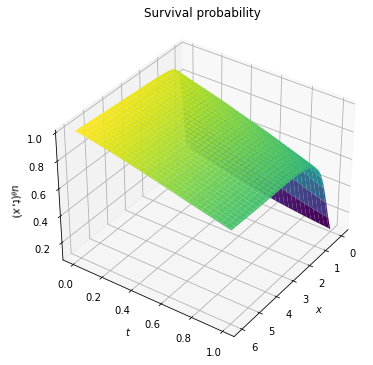

In [12]:
from mpl_toolkits.mplot3d import Axes3D

DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)
xmin = -6.0
xmax = 6.0

# Lower bounds
lb = tf.constant([xmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([xmax], dtype=DTYPE)
# Set up meshgrid
N = 100
tspace = np.linspace(0.0, 1.0, N + 1)
xspace = np.linspace(0, ub, N + 1)
rspace = np.array([0.0]*(N+1))
X, T = np.meshgrid(xspace, tspace)
Xgrid = np.vstack([X.flatten(),T.flatten()]).T

# Determine predictions of u(t, x)
Xgrid_pred = np.array([np.append(Xgrid[x],[1.0],axis=0) for x in range(len(Xgrid))])
upred = model_jump(tf.cast(Xgrid_pred,DTYPE))

# Reshape upred
U = 1-upred.numpy().reshape(N+1,N+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,T, U, cmap='viridis');
ax.view_init(35,35)
ax.set_xlabel('$x$')
ax.set_ylabel('$t$')
ax.set_zlabel('$u_\\theta(t,x)$')
ax.set_title('Survival probability');
#plt.savefig('Burgers_Solution.pdf', bbox_inches='tight', dpi=300);

In [37]:
xspace = np.linspace(0, ub, N + 1)
rspace = np.array([0.0]*(N+1))
X, T = np.meshgrid(xspace, tspace)
Xgrid = np.vstack([X.flatten(),T.flatten()]).T

In [20]:
xspace_jump = np.linspace(lb, ub, 1001)
X = np.meshgrid(xspace_jump)
Xgrid_jump = np.vstack([X]).T

In [33]:
upred

<tf.Tensor: shape=(1030301, 1), dtype=float32, numpy=
array([[9.9428916e-01],
       [9.9428916e-01],
       [9.9428916e-01],
       ...,
       [2.8741360e-04],
       [2.8741360e-04],
       [2.8741360e-04]], dtype=float32)>

In [21]:
upred_jump = model_jump(tf.cast(Xgrid_jump,DTYPE))

ValueError: Input 0 of layer sequential is incompatible with the layer: expected axis -1 of input shape to have value 2 but received input with shape (1001, 1)

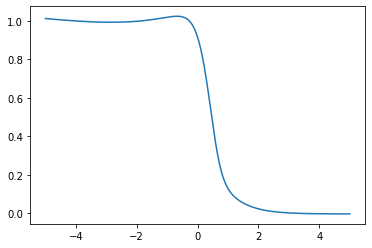

In [26]:
#upred = model_jump(tf.cast(Xgrid_jump,DTYPE))
plt.plot(xspace_jump, upred_jump)

In [4]:
# # with learning rate

# cases = [1, 2, 3, 4, 5]
# fig, ax = plt.subplots()

# for hidden in tqdm(cases):    
    
#     # Neural network parameters
#     num_hidden_layers = hidden
#     num_neurons_per_layer = 10

#     # Initializing the feedforwad neural network
#     model_jump = tf.keras.Sequential()

#     # Input is one-dimensional (only space & fixed time)
#     model_jump.add(tf.keras.Input(1))

#     # Scaling layer to map input to [lb, ub]
#     scaling_layer = tf.keras.layers.Lambda(lambda x:
#                                           2.0*(x-lb)/(ub-lb)-1.0)
#     model_jump.add(scaling_layer)

#     # Append hidden layers 
#     for _ in range(num_hidden_layers):
#             model_jump.add(tf.keras.layers.Dense(num_neurons_per_layer,
#                 activation=tf.keras.activations.get('softplus'),
#                 kernel_initializer='glorot_uniform'))

#     # Output is one-dimensional
#     model_jump.add(tf.keras.layers.Dense(1))

    
#     @tf.function
#     def train_step():
#     # Compute current loss and gradient w.r.t. parameters
#         loss, grad_theta = grad(model_jump, X_0_data, path_data_list)

#         # Perform gradient descent step
#         optim.apply_gradients(zip(grad_theta, model_jump.trainable_variables))

#         return loss



#     lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([2000,4000,6000,8000],[1e-1,1e-2,1e-3,1e-4, 1e-5])

#     # Choose the optimizer
#     optim = tf.keras.optimizers.Adam(learning_rate=lr)

#     # Number of training epochs
#     N = 10000
#     hist = []

#     # Start timer
#     t0 = time()

#     for i in tqdm(range(N+1)):

#         loss = train_step()

#         # Append current loss to hist
#         hist.append(loss.numpy())

#         # Output current loss after 50 iterates
#         if i%100 == 0:
#             print('It{}: loss = {}'.format(i,loss))

#     # Print computation time
#     print('\nComputation time: {} seconds'.format(time()-t0))
    
#     xspace_jump = np.linspace(lb, ub, 1001)
#     X = np.meshgrid(xspace_jump)
#     Xgrid_jump = np.vstack([X]).T
#     upred_jump = model_jump(tf.cast(Xgrid_jump,DTYPE))
#     ax.plot(xspace_jump, upred_jump, label=f'{hidden} hidden layers')
#     legend = ax.legend(loc='right', fontsize='x-small')
    
# plt.show()